In [103]:
from torch_geometric.datasets import Flickr
from torch_geometric.transforms import NormalizeFeatures, RandomNodeSplit
from torch_geometric.utils.convert import to_networkx
import networkx as nx
from tqdm.notebook import tqdm
from utils import *
import pandas as pd
import multiprocessing as mp
from tqdm.contrib.concurrent import process_map
from functools import partial
import pickle as pkl
import os

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
dataset = Flickr('data/Flickr')
data = dataset[0]
test_subgraph = data.subgraph(data.test_mask)
test_subgraph

Data(x=[22313, 500], edge_index=[2, 58636], y=[22313], train_mask=[22313], val_mask=[22313], test_mask=[22313])

In [105]:
G = to_networkx(test_subgraph).to_undirected()

In [106]:
G

In [107]:
def get_nbhd_weights(G, node, k, scheme='unif'):
    # Get dict containing nodes -> shortest path to node (i.e. depth).
    node_depth_map = pd.Series(nx.single_source_shortest_path_length(G, node, cutoff=k), name='distance')
    node_depth_map.index.name = 'node_id'
    node_depth_map = node_depth_map.drop(node) # Remove the node itself from list.
    node_depth_map = node_depth_map.reset_index()

    if scheme == 'geom':
        node_depth_map['weight'] = (0.5)**(node_depth_map['distance'] - 1)  # Weight =
    elif scheme == 'linear':
        node_depth_map['weight'] = 1 / node_depth_map['distance']
    else:
        node_depth_map['weight'] = 1
    return node_depth_map

In [108]:
# exp_path = 'experiments/09-09-2022_23-16-17_Flickr'
exp_path = 'experiments/12-09-2022_19-02-33_Flickr'
# exp_path = 'experiments/15-09-2022_00-22-32_Flickr_SHADOW'

# exp_path = 'experiments/15-09-2022_00-22-32_Flickr_SHADOW'
preds_path = os.path.join(exp_path, 'preds.pkl')
with open(preds_path, 'rb') as f:
    preds = pkl.load(f)
# preds = preds[lcc_nodes]
# test_x = test_subgraph.x[lcc_nodes].numpy()
# test_y = test_subgraph.y[lcc_nodes].numpy()
preds = pd.DataFrame(preds)
test_x = pd.DataFrame(data.x[data.test_mask].numpy())
test_y = pd.DataFrame(data.y[data.test_mask].numpy())

print(len(preds))
print(len(test_x))
print(len(test_y))

22313
22313
22313


In [109]:
probs = test_y.value_counts() / len(test_y)
probs.name = 'Proportion'
probs.index.name = 'Class'
probs
sum(probs**2)

0.26648471942681085

In [110]:
preds

,0,1,2,3,4,5,6
0,0.036017,0.021478,0.134114,0.145626,0.403663,0.011260,0.247843
1,0.040455,0.126701,0.072531,0.080866,0.434060,0.008651,0.236735
2,0.027937,0.211854,0.023462,0.017924,0.215684,0.018396,0.484743
3,0.040208,0.051802,0.097832,0.096968,0.416790,0.021567,0.274833
4,0.042943,0.058754,0.115049,0.108834,0.267035,0.023328,0.384058
...,...,...,...,...,...,...,...
22308,0.082469,0.066420,0.038205,0.028933,0.099289,0.011308,0.673377
22309,0.042790,0.058446,0.099815,0.095344,0.355005,0.030999,0.317602
22310,0.068607,0.027978,0.088292,0.099846,0.223262,0.032668,0.459346
22311,0.102788,0.026896,0.085457,0.053725,0.095484,0.068835,0.566816


In [111]:
G.number_of_nodes()

22313

In [112]:
## Compute the NAPS prediction set for each node in advance.
alpha = 0.1
cutoff = 50
quantiles_nb = []
def calibrate_nbhd(node, scheme='unif'):
    nbs = get_nbhd_weights(G, node, k=2, scheme=scheme)
    nb_ids = nbs['node_id'].values
    weights = nbs['weight'].values
    if cutoff <= len(nb_ids):
        quantile = calibrate_weighted(preds.loc[nb_ids].values,
                             np.squeeze(test_y.loc[nb_ids].values),
                                      weights, alpha)
        return {node: quantile}
# quantiles_nb = process_map(calibrate_nbhd, list(G.nodes), max_workers=12)

In [113]:
def precompute_naps_sets(scheme):
    f = partial(calibrate_nbhd, scheme=scheme)
    quantiles_nb = process_map(f, list(G.nodes), max_workers=12)
    nz = [p for p in quantiles_nb if p is not None]
    res = {}
    for p in nz:
        res.update(p)
    nbhd_quantiles = pd.Series(res, name='quantile')
    nbhd_quantiles
    lcc_nodes = nbhd_quantiles.index.values
    sets_nb = predict(preds.loc[lcc_nodes].values, nbhd_quantiles.values[:, None])
    sets_nb = pd.Series(sets_nb, index=lcc_nodes, name='set')
    sets_nb = pd.DataFrame(sets_nb)
    sets_nb['set_size'] = sets_nb['set'].apply(len)
    sets_nb['covers'] = [test_y.loc[i].values in sets_nb.loc[i, 'set'] for i in sets_nb.index.values]
    return sets_nb, lcc_nodes

In [114]:
naps_sets, lcc_nodes = precompute_naps_sets('unif')
napsl_sets, _ = precompute_naps_sets('linear')
napsg_sets, _ = precompute_naps_sets('geom')

/tmp/ipykernel_160390/3871286286.py:3: TqdmWarning: Iterable length 22313 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  quantiles_nb = process_map(f, list(G.nodes), max_workers=12)


  0%|          | 0/22313 [00:00<?, ?it/s]

/tmp/ipykernel_160390/3871286286.py:3: TqdmWarning: Iterable length 22313 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  quantiles_nb = process_map(f, list(G.nodes), max_workers=12)


  0%|          | 0/22313 [00:00<?, ?it/s]

/tmp/ipykernel_160390/3871286286.py:3: TqdmWarning: Iterable length 22313 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  quantiles_nb = process_map(f, list(G.nodes), max_workers=12)


  0%|          | 0/22313 [00:00<?, ?it/s]

In [115]:
naps_sets.groupby('set_size').count()

,set,covers
set_size,,
1,20,20
2,262,262
3,1144,1144
4,1839,1839
5,1522,1522
6,419,419
7,23,23


In [116]:
len(lcc_nodes)

5229

In [117]:
n_trials = 100
n_eval = 1000
sccv_bins = [-1, 2, 3, 4, 7]

In [118]:
naps_stats = []
napsl_stats = []
napsg_stats = []
full_stats = []
# with mp.Pool(12) as p:
for k in tqdm(range(n_trials)):
    ## Sample the prediction nodes.
    pred_nodes = np.random.choice(lcc_nodes, size=n_eval, replace=False)
    # Neighbourhood calibration is pre-computed, so just get prediction sets for them.
    naps_stats.append(evaluate_predictions(naps_sets.loc[pred_nodes, 'set'].values,
                                         test_x.loc[pred_nodes].values,
                                         np.squeeze(test_y.loc[pred_nodes].values), alpha, sccv_bins
                                         ))
    napsl_stats.append(evaluate_predictions(napsl_sets.loc[pred_nodes, 'set'].values,
                                         test_x.loc[pred_nodes].values,
                                         np.squeeze(test_y.loc[pred_nodes].values), alpha, sccv_bins
                                         ))
    napsg_stats.append(evaluate_predictions(napsg_sets.loc[pred_nodes, 'set'].values,
                                         test_x.loc[pred_nodes].values,
                                         np.squeeze(test_y.loc[pred_nodes].values), alpha, sccv_bins
                                         ))

    # Full calibration
    quantile = calibrate(preds[~preds.index.isin(pred_nodes)].values,
                         np.squeeze(test_y[~test_y.index.isin(pred_nodes)].values), alpha)
    sets_full = predict(preds.loc[pred_nodes].values, quantile)
    full_stats.append(evaluate_predictions(sets_full,
                                           test_x.loc[pred_nodes].values,
                                           np.squeeze(test_y.loc[pred_nodes].values), alpha, sccv_bins))


  0%|          | 0/100 [00:00<?, ?it/s]

[0.8, 0.8412017167381974, 0.9235474006116208, 0.9194805194805195]
[0.8222222222222222, 0.8883495145631068, 0.8924050632911392, 0.9399538106235565]
[0.7948717948717948, 0.8921568627450981, 0.9046153846153846, 0.9236111111111112]
[0.9375, 0.87248322147651, 0.8949880668257757, 0.9254807692307693]
[0.8518518518518519, 0.9166666666666666, 0.8907563025210085, 0.925207756232687]
[0.8823529411764706, 0.8985507246376812, 0.911504424778761, 0.9261904761904762]
[0.7777777777777778, 0.9150943396226415, 0.9077809798270894, 0.9185185185185185]
[0.8235294117647058, 0.8636363636363636, 0.8917647058823529, 0.9282178217821783]
[0.7804878048780488, 0.9041095890410958, 0.9090909090909091, 0.9336870026525199]
[0.7714285714285715, 0.8938547486033519, 0.9140401146131805, 0.931350114416476]
[0.7567567567567568, 0.898936170212766, 0.8994252873563219, 0.9437939110070258]
[0.8235294117647058, 0.85625, 0.9129353233830846, 0.9097387173396675]
[0.8269230769230769, 0.8177570093457944, 0.9023668639053254, 0.919191919

,coverage,set_size,cc_set_size,sscv
count,100.00000,100.000000,100.000000,100.000000
mean,0.90483,4.134580,4.164487,0.077530
std,0.00860,0.027218,0.029175,0.037005
min,0.88500,4.063000,4.092031,0.013208
25%,0.89975,4.113750,4.141117,0.047475
50%,0.90650,4.134000,4.163456,0.075439
75%,0.91000,4.157250,4.186828,0.100926
max,0.92300,4.190000,4.229120,0.180000


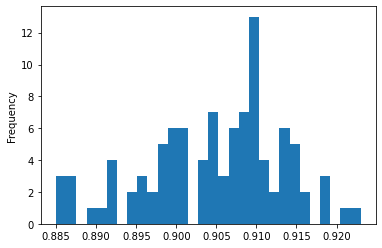

In [129]:
nb_df = pd.DataFrame(naps_stats, columns=['coverage', 'set_size', 'cc_set_size', 'sscv'])
nb_df['coverage'].plot(kind='hist', bins=30)
nb_df.describe()

,coverage,set_size,cc_set_size,sscv
count,100.00000,100.000000,100.000000,100.000000
mean,0.91304,4.286210,4.310891,0.074417
std,0.00786,0.028658,0.028908,0.043342
min,0.89400,4.231000,4.254405,0.010314
25%,0.90800,4.263750,4.284225,0.039546
50%,0.91350,4.285500,4.311394,0.064729
75%,0.91900,4.308000,4.332334,0.100000
max,0.93000,4.361000,4.371991,0.181250


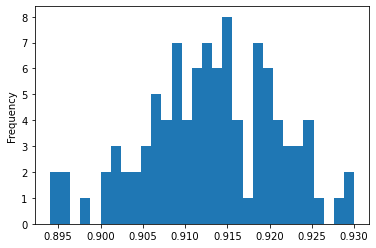

In [130]:
nb_df = pd.DataFrame(napsl_stats, columns=['coverage', 'set_size', 'cc_set_size', 'sscv'])
nb_df['coverage'].plot(kind='hist', bins=30)
nb_df.describe()

,coverage,set_size,cc_set_size,sscv
count,100.000000,100.000000,100.000000,100.000000
mean,0.913230,4.301130,4.324994,0.078977
std,0.007421,0.029601,0.030472,0.043641
min,0.893000,4.221000,4.243094,0.016849
25%,0.909750,4.283750,4.305402,0.039535
50%,0.914000,4.301000,4.326651,0.076471
75%,0.918000,4.321000,4.342961,0.105317
max,0.928000,4.374000,4.395580,0.212500


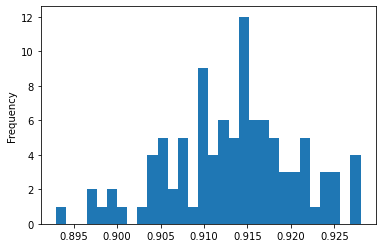

In [131]:
nb_df = pd.DataFrame(napsg_stats, columns=['coverage', 'set_size', 'cc_set_size', 'sscv'])
nb_df['coverage'].plot(kind='hist', bins=30)
nb_df.describe()


,coverage,set_size,cc_set_size,sscv
count,100.000000,100.000000,100.000000,100.000000
mean,0.907050,4.263910,4.280219,0.086718
std,0.008087,0.030271,0.030011,0.060459
min,0.885000,4.207000,4.224176,0.011111
25%,0.901000,4.242000,4.258089,0.041176
50%,0.908000,4.262000,4.277136,0.066667
75%,0.912250,4.280500,4.300413,0.116270
max,0.925000,4.353000,4.372247,0.288889


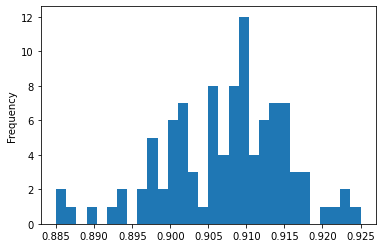

In [132]:
full_df = pd.DataFrame(full_stats, columns=['coverage', 'set_size', 'cc_set_size', 'sscv'])
full_df['coverage'].plot(kind='hist', bins=30)
full_df.describe()

In [123]:
from random import sample
## Split the test nodes into non-overlapping neighbourhoods
def split_into_neighbourhoods(test_nodes):
    test_subgraph = G.subgraph(test_nodes).copy()
    nbhds = []
    while test_subgraph.number_of_nodes() > 0:
        root = sample(list(test_subgraph.nodes()), 1)[0]
        nbhd_nodes = list(nx.single_source_shortest_path_length(test_subgraph, root, cutoff=2).keys())
        nbhds.append(nbhd_nodes)
        test_subgraph.remove_nodes_from(nbhd_nodes)
    return sorted(nbhds, key=lambda x: len(x), reverse=True)[:10]

In [124]:
aps_nccvs = []
naps_nccvs = []
napsl_nccvs = []
napsg_nccvs = []
for k in tqdm(range(n_trials)):
    np.random.shuffle(lcc_nodes)
    n_calib = len(lcc_nodes) // 2
    calib_nodes = lcc_nodes[:n_calib]
    test_nodes = lcc_nodes[n_calib:]

    ## Calibrate the regular CP on calibration nodes and make predictions on test nodes
    quantile = calibrate(preds.loc[calib_nodes].values,
                         np.squeeze(test_y.loc[calib_nodes].values), alpha)
    sets_full = pd.Series(predict(preds.loc[test_nodes].values, quantile), index=test_nodes)
    nbhds = split_into_neighbourhoods(test_nodes)
    aps_nb_coverages = []
    naps_nb_coverages = []
    napsl_nb_coverages = []
    napsg_nb_coverages = []

    for nbhd in nbhds:
        aps_nb_coverages.append(np.mean([test_y.loc[node].item() in sets_full[node] for node in nbhd]))
        naps_nb_coverages.append(naps_sets.loc[nbhd, 'covers'].mean())
        napsl_nb_coverages.append(napsl_sets.loc[nbhd, 'covers'].mean())
        napsg_nb_coverages.append(napsg_sets.loc[nbhd, 'covers'].mean())

    aps_nccv = max(np.abs(np.array(aps_nb_coverages) - (1 - alpha)))
    naps_nccv = max(np.abs(np.array(naps_nb_coverages) - (1 - alpha)))
    napsl_nccv = max(np.abs(np.array(napsl_nb_coverages) - (1 - alpha)))
    napsg_nccv = max(np.abs(np.array(napsg_nb_coverages) - (1 - alpha)))

    aps_nccvs.append(aps_nccv)
    naps_nccvs.append(naps_nccv)
    napsl_nccvs.append(napsl_nccv)
    napsg_nccvs.append(napsg_nccv)


  0%|          | 0/100 [00:00<?, ?it/s]

In [125]:
pd.DataFrame(aps_nccvs).describe()

,0
count,100.000000
mean,0.088098
std,0.024404
min,0.038728
25%,0.072024
50%,0.083046
75%,0.100000
max,0.172727


In [126]:
pd.DataFrame(naps_nccvs).describe()

,0
count,100.000000
mean,0.061962
std,0.021056
min,0.016279
25%,0.049734
50%,0.057895
75%,0.074013
max,0.155814


In [127]:
pd.DataFrame(napsl_nccvs).describe()

,0
count,100.000000
mean,0.064118
std,0.019765
min,0.019048
25%,0.051220
50%,0.063588
75%,0.076190
max,0.109302


In [128]:
pd.DataFrame(napsg_nccvs).describe()

,0
count,100.000000
mean,0.066124
std,0.019133
min,0.023077
25%,0.052381
50%,0.066288
75%,0.076671
max,0.109302
